In [1]:
# Import libraries

import os                           # Python version: 3.11.4
import shutil                       # Python version: 3.11.4
import textwrap                     # Python version: 3.11.4
import random                       # Python version: 3.11.4
import pandas as pd                 # Version: 1.5.3
import numpy as np                  # Version: 1.24.3
import matplotlib.pyplot as plt     # Matplotlib version: 3.8.2
from IPython.display import Image, display      # IPython version: 8.12.0

In [2]:
# Go from the current notebooks folder to the data folder (target_dir), its file path will be used to import and export data files
notebook_dir = os.getcwd()
parent_dir   = os.path.dirname(notebook_dir)
target_dir   = os.path.join(parent_dir, "data")

### **STEP 1**: **LABELING IMAGES WITH PLANT ID**

#### 1.1 **Approximating Crop Locations**

##### 1.1.1 **Preprocess Navigation Data**

In [ ]:
# Import navigation data for all four beds, specify bed, and concatenate
bed01_path = os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_01", "navigation.csv")
bed02_path = os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_02", "navigation.csv")
bed03_path = os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_03", "navigation.csv")
bed04_path = os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_04", "navigation.csv")

bed01_navigation = pd.read_csv(bed01_path, skiprows = 29)
bed02_navigation = pd.read_csv(bed02_path, skiprows = 29)
bed03_navigation = pd.read_csv(bed03_path, skiprows = 29)
bed04_navigation = pd.read_csv(bed04_path, skiprows = 29)

bed01_navigation["bed"] = 1
bed02_navigation["bed"] = 2
bed03_navigation["bed"] = 3
bed04_navigation["bed"] = 4

navigation = pd.concat([bed01_navigation, bed02_navigation, bed03_navigation, bed04_navigation], ignore_index = True)

# Remove whitespace
navigation = navigation.applymap(lambda x: x.strip() if isinstance(x, str) else x)
navigation.columns = navigation.columns.str.strip()
# Display
display(navigation.head(10).style.format({"x": "{:.8f}"}))

# Split the timestamp for processing
# tsP1 is time in UTC (ISO 8601 compliant string: [YYYY][MM][DD]T[hh][mm][ss])
# tsP2 are zero-padded (6 digits) integers representing the microsecond
navigation[["tsP1", "tsP2"]] = navigation["timestamp"].str.split(".", expand = True)
navigation["tsP2"] = pd.to_numeric(navigation["tsP2"], errors = "coerce")

tsP2_list = {}
for number in navigation["bed"].unique():
    bed_data = navigation[navigation["bed"] == number]
    tsP2_list[number] = sorted(bed_data["tsP2"].unique().tolist())

print("UNIQUE VALUES IN tsP2:")
for bed, microseconds in tsP2_list.items():
    print(f"Bed {bed}: {microseconds}")

,timestamp,x,y,z,roll,pitch,yaw,bed
0,20171115T005555.250000,6232843.88795536,284207.076052,-86.608518,0.005412,0.027939,0.176570,1
1,20171115T005555.255000,6232843.88774659,284207.076053,-86.608559,0.005388,0.027909,0.176527,1
2,20171115T005555.299999,6232843.88815683,284207.076032,-86.608466,0.005404,0.027966,0.176585,1
3,20171115T005555.359999,6232843.88835192,284207.075924,-86.608394,0.005443,0.028042,0.176559,1
4,20171115T005555.400000,6232843.88843941,284207.075827,-86.608362,0.005490,0.028031,0.176535,1
5,20171115T005555.450000,6232843.88856482,284207.075733,-86.608322,0.005499,0.028034,0.176575,1
6,20171115T005555.500000,6232843.88870234,284207.075682,-86.608260,0.005478,0.028099,0.176600,1
7,20171115T005555.549999,6232843.88887276,284207.075658,-86.608231,0.005497,0.028137,0.176589,1
8,20171115T005555.609999,6232843.88912295,284207.075624,-86.608145,0.005502,0.028154,0.176560,1
9,20171115T005555.650000,6232843.88928888,284207.075585,-86.608118,0.005505,0.028071,0.176496,1


UNIQUE VALUES IN tsP2:
Bed 1: [0, 49999, 109999, 150000, 200000, 250000, 255000, 299999, 359999, 400000, 450000, 500000, 549999, 609999, 650000, 700000, 750000, 799999, 859999, 900000, 950000]
Bed 2: [0, 49999, 109999, 150000, 200000, 250000, 299999, 359999, 400000, 450000, 500000, 549999, 595000, 609999, 650000, 700000, 750000, 799999, 859999, 900000, 950000]
Bed 3: [0, 49999, 109999, 150000, 200000, 250000, 299999, 359999, 400000, 450000, 500000, 549999, 609999, 650000, 700000, 750000, 799999, 859999, 900000, 950000]
Bed 4: [0, 9999, 49999, 109999, 119999, 150000, 200000, 250000, 299999, 301000, 359999, 400000, 408999, 450000, 460000, 500000, 549999, 609999, 650000, 700000, 750000, 799999, 809999, 859999, 869999, 900000, 908999, 950000]


##### 1.1.2 **Extract Information from Navigation Data**

In [ ]:
# Images where the first crop occurs for the given bed
# Images are chosen where the crop is in the center (manually identified)
first = {
    "bed": [1, 2, 3, 4],
    "timestamp": [
        "20171115T005754.602903", # .png
        "20171115T012511.047478", # .png
        "20171115T013001.955678", # .png
        "20171115T015648.844658"  # .png
    ]
}

first = pd.DataFrame(first)
first[["tsP1", "tsP2"]] = first["timestamp"].str.split(".", expand = True)
first["tsP2"] = pd.to_numeric(first["tsP2"], errors = "coerce")

# Rounding the tsP2 value to the closest in tsP2_list for the corresponding bed
first["tsP2_rounded"] = first.apply(lambda row: min(tsP2_list[row["bed"]], key = lambda ref: abs(row["tsP2"] - ref)), axis = 1)
first["tsP2_rounded"] = first["tsP2_rounded"].apply(lambda x: f"{x:06}")
first["timestamp_rounded"] = first.apply(lambda row: f'{row["tsP1"]}.{row["tsP2_rounded"]}', axis = 1)
# Beginning "x" coordinate (local northing) based on first image for the corresponding bed
first["beginning_x"] = first["timestamp_rounded"].apply(lambda ts: navigation.loc[navigation["timestamp"] == ts, "x"].iloc[0])

# Standard "y" coordinate (local easting) based on minimum for the corresponding bed
first["standard_y"] = first["bed"].apply(lambda n: navigation.loc[navigation["bed"] == n, "y"].min())

In [ ]:
# Images where the last crop occurs for the given bed
# Images are chosen where the crop is in the center (manually identified)
end = {
    "bed": [1, 2, 3, 4],
    "timestamp": [
        "20171115T011019.553455", # .png
        "20171115T011249.110078", # .png
        "20171115T014221.957559", # .png
        "20171115T014423.863766"  # .png
    ]
}

end = pd.DataFrame(end)
end[["tsP1", "tsP2"]] = end["timestamp"].str.split(".", expand = True)
end["tsP2"] = pd.to_numeric(end["tsP2"], errors = "coerce")

# Rounding the tsP2 value to the closest in tsP2_list for the corresponding bed
end["tsP2_rounded"] = end.apply(lambda row: min(tsP2_list[row["bed"]], key = lambda ref: abs(row["tsP2"] - ref)), axis = 1)
end["tsP2_rounded"] = end["tsP2_rounded"].apply(lambda x: f"{x:06}")
end["timestamp_rounded"] = end.apply(lambda row: f'{row["tsP1"]}.{row["tsP2_rounded"]}', axis = 1)
# End "x" coordinate (local northing) based on first image for the corresponding bed
end["end_x"] = end["timestamp_rounded"].apply(lambda ts: navigation.loc[navigation["timestamp"] == ts, "x"].iloc[0])

##### 1.1.3 **Create Field Layout**

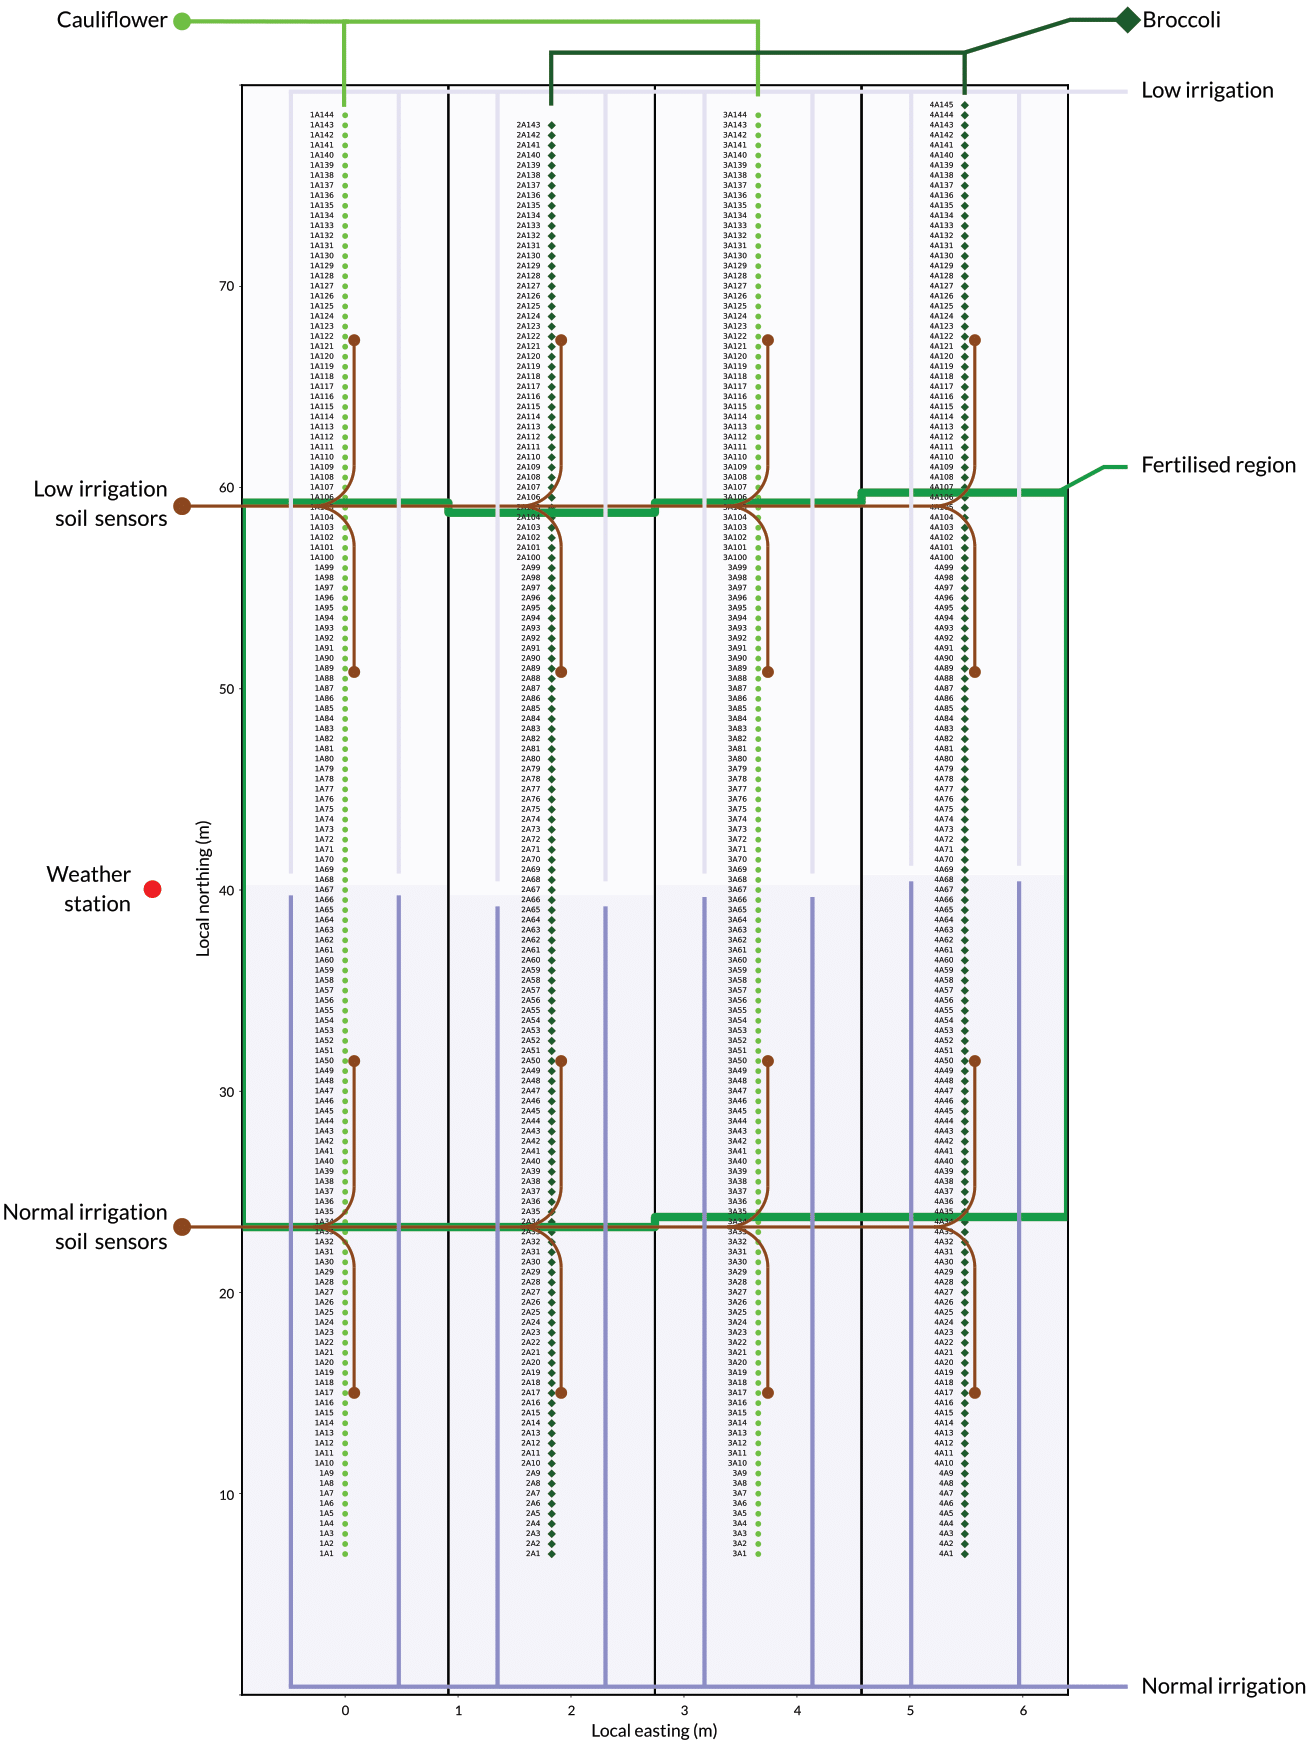

Image for reference from: Bender, A., Whelan, B., & Sukkarieh, S. (2020). A
high-resolution, multi-modal data set for agricultural robotics: A
ladybird’s-eye view of brassica. Journal of Field Robotics, 37(1), 73–96.
https://doi.org/10.1002/rob.21877


In [3]:
image_path = os.path.join(target_dir, "A_raw_data", "field_layout.png")
display(Image(filename = image_path, width = 600))

reference  = textwrap.wrap("Image for reference from: Bender, A., Whelan, B., & Sukkarieh, S. (2020). A high-resolution, multi-modal data set for agricultural robotics: A ladybird’s-eye view of brassica. Journal of Field Robotics, 37(1), 73–96. https://doi.org/10.1002/rob.21877", 
                           width = 80)
for line in reference:
    print(line)

In [149]:
# Adjust plant_spacing 

last_crops = {
    1: {"ID": "1A143", "actual_position": end.loc[end["bed"] == 1, "end_x"].iloc[0]},
    2: {"ID": "2A143", "actual_position": end.loc[end["bed"] == 2, "end_x"].iloc[0]},
    3: {"ID": "3A138", "actual_position": end.loc[end["bed"] == 3, "end_x"].iloc[0]},
    4: {"ID": "4A145", "actual_position": end.loc[end["bed"] == 4, "end_x"].iloc[0]}
}

bed_easting = dict(zip(first["bed"], first["standard_y"]))
beginning_northing = dict(zip(first["bed"], first["beginning_x"]))

# Calculate discrepancies and adjust plant spacing for more accurate positioning
initial_spacing  = 0.5 # plant_spacing acquired from dataset documentation
adjusted_spacing = initial_spacing

for bed, last_crop_info in last_crops.items():
    expected_position = beginning_northing[bed] + int(last_crop_info["ID"][2:]) * adjusted_spacing
    discrepancy = last_crop_info["actual_position"] - expected_position
    print(f"Bed {bed}: Expected Position = {expected_position:.8f}, Actual Position = {last_crop_info['actual_position']:.8f}, Discrepancy = {discrepancy:.8f}")

    crop_count = int(last_crop_info["ID"][2:])
    adjusted_spacing += discrepancy / crop_count 
print(f"Adjusted Plant Spacing: {adjusted_spacing:.8f}")

Bed 1: Expected Position = 6232925.49186662, Actual Position = 6232924.30235877, Discrepancy = -1.18950786
Bed 2: Expected Position = 6232924.10423019, Actual Position = 6232924.18995954, Discrepancy = 0.08572935
Bed 3: Expected Position = 6232920.97940317, Actual Position = 6232923.12067370, Discrepancy = 2.14127052
Bed 4: Expected Position = 6232926.40519791, Actual Position = 6232923.57553027, Discrepancy = -2.82966763
Adjusted Plant Spacing: 0.48828277


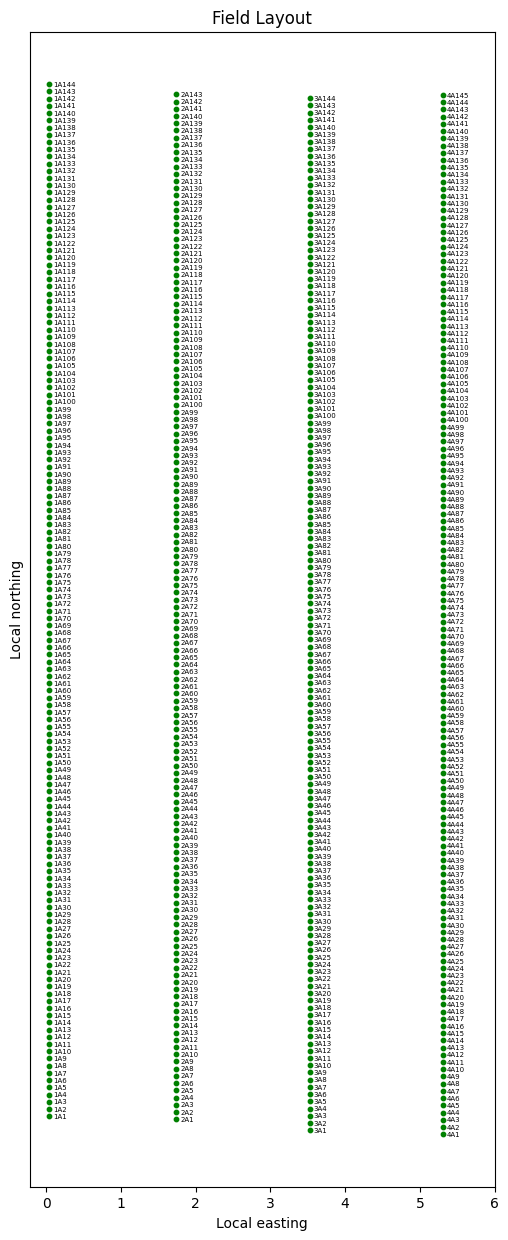

In [210]:
# Approximate positions of crops

plant_IDs = []

plant_IDs += [f"1A{x}" for x in range(1, 145)]
plant_IDs += [f"2A{x}" for x in range(1, 144)]
plant_IDs += [f"3A{x}" for x in range(1, 145)]
plant_IDs += [f"4A{x}" for x in range(1, 146)]

plant_spacing = adjusted_spacing
bed_easting = dict(zip(first["bed"], first["standard_y"]))
beginning_northing = dict(zip(first["bed"], first["beginning_x"]))

positions = []
for ID in plant_IDs:
    bed = int(ID[0])
    local_easting  = bed_easting[bed]
    local_northing = beginning_northing[bed] + (int(ID[2:]) * adjusted_spacing) - adjusted_spacing
    positions.append({"ID": ID, "Bed": bed, "local_northing": local_northing, "local_easting": local_easting})

field_layout = pd.DataFrame(positions)

plt.figure(figsize = (6, 15))
plt.scatter(field_layout["local_easting"], field_layout["local_northing"], c = "green", s = 10)

for i, row in field_layout.iterrows():
    plt.text(row["local_easting"] + 0.05, row["local_northing"], row["ID"], fontsize = 5, ha = "left", va = "center")

plt.xlabel("Local easting")
plt.ylabel("Local northing")
plt.title("Field Layout")
plt.xticks(np.arange(284207, 284214, step = 1), np.arange(0, 7, step = 1))
plt.yticks([])
plt.show()

#### 1.2 **Label Images with Plant IDs**

##### 1.2.1 **Label Based on Timestamp and Field Layout**

In [155]:
bed01_path = os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_01", "grasshopper3-left", "md5sum.txt")
bed02_path = os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_02", "grasshopper3-left", "md5sum.txt")
bed03_path = os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_03", "grasshopper3-left", "md5sum.txt")
bed04_path = os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_04", "grasshopper3-left", "md5sum.txt")

bed01_names = pd.read_csv(bed01_path, delimiter = " ", header = None)
bed02_names = pd.read_csv(bed02_path, delimiter = " ", header = None)
bed03_names = pd.read_csv(bed03_path, delimiter = " ", header = None)
bed04_names = pd.read_csv(bed04_path, delimiter = " ", header = None)

bed01_names["Bed"] = 1
bed02_names["Bed"] = 2
bed03_names["Bed"] = 3
bed04_names["Bed"] = 4

left = pd.concat([bed01_names, bed02_names, bed03_names, bed04_names], ignore_index = True)
left["Camera"] = "LEFT"

# Clean up columns
left = left.drop(columns = left.columns[[0, 1]])
left = left.rename(columns = {2: "Old filename"})
left["Old filename"] = left["Old filename"].str.replace(r"\./", "", regex = True)
left["Timestamp"] = left["Old filename"].str.replace(r"\.png", "", regex = True)

# tsP1, tsP2
left[["tsP1", "tsP2"]] = left["Timestamp"].str.split(".", expand = True)
left["tsP2"] = pd.to_numeric(left["tsP2"], errors = "coerce")

# Rounding the tsP2 value to the closest in tsP2_list for the corresponding bed
left["tsP2_rounded"] = left.apply(lambda row: min(tsP2_list[row["Bed"]], key = lambda ref: abs(row["tsP2"] - ref)), axis = 1)
left["tsP2_rounded"] = left["tsP2_rounded"].apply(lambda x: f"{x:06}")
left["Timestamp_rounded"] = left.apply(lambda row: f'{row["tsP1"]}.{row["tsP2_rounded"]}', axis = 1)

# Find timestamp in navigation
left = left.merge(navigation[["timestamp", "x"]], left_on = "Timestamp_rounded", right_on = "timestamp", how = "left")
left = left.drop(columns = "timestamp")

# Find closest in navigation if merge did not result in x
for index, row in left.iterrows():
    if pd.isnull(row["x"]):
        matching_tsP1 = navigation[navigation["timestamp"].str.startswith(row["tsP1"])].copy()
        if not matching_tsP1.empty:
            matching_tsP1["tsP2"] = matching_tsP1["timestamp"].str.split(".", expand = True)[1].astype(float)
            closest_idx = (matching_tsP1["tsP2"] - row["tsP2"]).abs().idxmin()
            left.at[index, "x"] = matching_tsP1.at[closest_idx, "x"]

# Assign ID from field layout based on bed and x
left["ID"] = None

for index, row in left.iterrows():
    bed_layout = field_layout[field_layout["Bed"] == row["Bed"]]
    closest_idx = (bed_layout["local_northing"] - row["x"]).abs().idxmin()
    left.at[index, "ID"] = bed_layout.at[closest_idx, "ID"]

display(left.head(5).style.format({"x": "{:.8f}"}))

,Old filename,Bed,Camera,Timestamp,tsP1,tsP2,tsP2_rounded,Timestamp_rounded,x,ID
0,20171115T005558.759661.png,1,LEFT,20171115T005558.759661,20171115T005558,759661,750000,20171115T005558.750000,6232843.88799077,1A1
1,20171115T005559.752494.png,1,LEFT,20171115T005559.752494,20171115T005559,752494,750000,20171115T005559.750000,6232843.89038224,1A1
2,20171115T005600.750795.png,1,LEFT,20171115T005600.750795,20171115T005600,750795,750000,20171115T005600.750000,6232843.88981350,1A1
3,20171115T005601.749878.png,1,LEFT,20171115T005601.749878,20171115T005601,749878,750000,20171115T005601.750000,6232843.88871078,1A1
4,20171115T005602.755278.png,1,LEFT,20171115T005602.755278,20171115T005602,755278,750000,20171115T005602.750000,6232843.88974308,1A1


##### 1.2.2 **Trim to Relevant Images for Both the Left and Right Camera**

In [ ]:
# Manually identify first crop image and last crop image
trim = {
    "bed": [1, 2, 3, 4],
    "start value": [
        "20171115T005751.596317.png", 
        "20171115T011247.117985.png", 
        "20171115T012959.981368.png",
        "20171115T014421.848238.png"
    ],
    "end value": [
        "20171115T011021.562848.png", 
        "20171115T012513.046641.png", 
        "20171115T014222.952300.png",
        "20171115T015651.814757.png"
    ]
}

trim = pd.DataFrame(trim)

# Trim everything before start value and after end value (per bed)
trimmed_left = []

for _, row in trim.iterrows():
    bed         = row["bed"]
    start_value = row["start value"]
    end_value   = row["end value"]
    left_bed    = left[left["Bed"] == bed]

    start_index = left_bed[left_bed["Old filename"] == start_value].index[0]
    end_index   = left_bed[left_bed["Old filename"] == end_value].index[0]

    trimmed_left.append(left_bed.loc[start_index:end_index])

left = pd.concat(trimmed_left).reset_index(drop = True)

# Create new filename
left["New filename"] = left.groupby("ID").cumcount() + 1
left["New filename"] = left["ID"] + left["New filename"].apply(lambda x: f"_L{x}.png")
left["Old filename2"] = "L_" + left["Timestamp"] + ".png"

# Duplicate and adjust for right
right = left.copy()
right["Camera"] = "RIGHT"
right["New filename"] = right["New filename"].str.replace("_L", "_R", regex = False)
right["Old filename2"] = right["Old filename2"].str.replace("L_", "R_", regex = False)

# Combine
combined = pd.concat([left, right], ignore_index = True)

##### 1.2.3 **Filter to Highlight the Relevant IDs**

In [ ]:
imp_csv_path = os.path.join(target_dir, "B_processed_data", "B_crop_data.csv")
B_crop_data = pd.read_csv(imp_csv_path)

# Filter to only rows where ID exists in B_crop_data
filtered_combined = combined.copy()
filtered_combined = filtered_combined[filtered_combined["ID"].isin(B_crop_data["ID"])].reset_index(drop = True)
filtered_combined["New filename"] = (
    filtered_combined["Camera"].str[0] + "_" +
    filtered_combined["Timestamp"]+ "_" +
    filtered_combined["New filename"]
)

# Merge filtered_combined onto combined based on "Old filename"
merged_combined = combined.merge(
    filtered_combined[["Old filename2", "New filename"]],
    on = "Old filename2",
    how = "left",
    suffixes = ("", "_filtered")
)

# Update the "New filename" column:
# - If the "New filename" from filtered_combined exists, use it
# - Otherwise, use the "Old filename" from combined
merged_combined["New filename"] = merged_combined["New filename_filtered"].fillna(merged_combined["Old filename2"])

##### 1.2.4 **Copy Raw Images to New Folder and Create Overview**

In [ ]:
image_sources = {
    1: {"left": os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_01", "grasshopper3-left"),
        "right": os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_01", "grasshopper3-right")
    },
    2: {"left": os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_02", "grasshopper3-left"),
        "right": os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_02", "grasshopper3-right")
    },
    3: {"left": os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_03", "grasshopper3-left"),
        "right": os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_03", "grasshopper3-right")
    },
    4: {"left": os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_04", "grasshopper3-left"),
        "right": os.path.join(target_dir, "A_raw_data", "autonomous_20171115_week_06", "bed_04", "grasshopper3-right")
    }
}

# Copy images filed in merged_combined to B_processed_data png_files under New filename
image_destination = os.path.join(target_dir, "B_processed_data", "png_files")

for i, row in merged_combined.iterrows():
    bed_number   = row["Bed"]
    camera_side  = row["Camera"].lower()
    image_source = image_sources[bed_number][camera_side]
    
    raw_image = os.path.join(image_source, row["Old filename"])
    new_image = os.path.join(image_destination, row["New filename"])

    shutil.copy(raw_image, new_image)

# Add to crop_images overview
crop_images = pd.DataFrame(columns = ["Filename", "ID", "Bed", "Camera", "Timestamp"])

filenames  = merged_combined["New filename"]
IDs        = merged_combined["ID"]
bed        = merged_combined["Bed"]
camera     = merged_combined["Camera"]
timestamps = merged_combined["Timestamp"]

for filename, ID, bed, camera, timestamp in zip(filenames, IDs, bed, camera, timestamps):
    if filename not in crop_images["Filename"].tolist():
        new_row = {"Filename": filename, "ID": ID, "Bed": bed, "Camera": camera, "Timestamp": timestamp}
        crop_images = pd.concat([crop_images, pd.DataFrame([new_row])], ignore_index = True)

display(crop_images.tail(5))
print(crop_images.shape)

exp_csv_path = os.path.join(target_dir, "B_processed_data", "png_files", "crop_images.csv")
crop_images.to_csv(exp_csv_path, index = False)

,Filename,ID,Bed,Camera,Timestamp
5989,R_20171115T015647.855871_4A1_R2.png,4A1,4,RIGHT,20171115T015647.855871
5990,R_20171115T015648.844658_4A1_R3.png,4A1,4,RIGHT,20171115T015648.844658
5991,R_20171115T015649.861590_4A1_R4.png,4A1,4,RIGHT,20171115T015649.861590
5992,R_20171115T015650.825910_4A1_R5.png,4A1,4,RIGHT,20171115T015650.825910
5993,R_20171115T015651.814757_4A1_R6.png,4A1,4,RIGHT,20171115T015651.814757


(5994, 5)


#### 1.3 **Manually Correct Plant IDs**

In [173]:
imp_csv_path = os.path.join(target_dir, "B_processed_data", "png_files", "crop_images (corrected).csv")
crop_images_corrected = pd.read_csv(imp_csv_path)

# Replace ID's with manually corrected ID's (ID_corrected)
crop_images_corrected.loc[crop_images_corrected["ID_corrected"].notnull(), "ID"] = crop_images_corrected["ID_corrected"]
crop_images_corrected = crop_images_corrected.drop(columns = "ID_corrected")

# [ ]
for index, row in crop_images_corrected.iterrows():
    old_filename = os.path.join(target_dir, "B_processed_data", "png_files", row["Filename"])
    
    # If New_filename is NaN, the image is removed
    if pd.isna(row["New_filename"]):
        # Check if the file exists (under the old filename)
        if os.path.exists(old_filename):
            os.remove(old_filename)
    # If New_filename is not NaN, we change the old filename into New_filename
    else:
        new_filename = os.path.join(target_dir, "B_processed_data", "png_files", row["New_filename"])
        # Check if the file exists (under the old filename)
        if os.path.exists(old_filename):
            os.rename(old_filename, new_filename)

crop_images_corrected = crop_images_corrected.drop(columns = "Filename")
crop_images_corrected = crop_images_corrected.dropna(subset = "New_filename")
display(crop_images_corrected.head(10))

,New_filename,ID,Crop_position,Bed,Camera,Timestamp
6,1A2_L1.png,1A2,TOP,1,LEFT,20171115T005757.603789
7,1A2_L2.png,1A2,TOP,1,LEFT,20171115T005758.601923
8,1A2_L3.png,1A2,CENTER,1,LEFT,20171115T005759.589128
9,1A2_L4.png,1A2,BOTTOM,1,LEFT,20171115T005800.587644
10,1A2_L5.png,1A2,BOTTOM,1,LEFT,20171115T005801.592059
16,1A4_L1.png,1A4,TOP,1,LEFT,20171115T005807.608158
17,1A4_L2.png,1A4,TOP,1,LEFT,20171115T005808.581335
18,1A4_L3.png,1A4,CENTER,1,LEFT,20171115T005809.581048
19,1A4_L4.png,1A4,BOTTOM,1,LEFT,20171115T005810.580941
20,1A4_L5.png,1A4,BOTTOM,1,LEFT,20171115T005811.565567


### **STEP 2**: **PREPROCESSING IMAGES**

#### 2.1 **Convert to Color and Correct Illumination**

Part of the code in the cell below is adapted from the example code supplied with the dataset (http://hdl.handle.net/2123/20187). Specifically, the loading and converting of the crop sample images, and correcting the flash illumination.

In [175]:
import cv2
from numpy import iinfo

flatfield_sources = {
    1: {"left": os.path.join(target_dir, "A_raw_data", "autonomous_annotations_calibrations_and_example_code", "calibrations", "grasshopper3", "flatfield-left.png"),
        "right": os.path.join(target_dir, "A_raw_data", "autonomous_annotations_calibrations_and_example_code", "calibrations", "grasshopper3", "flatfield-right.png")
    },
    2: {"left": os.path.join(target_dir, "A_raw_data", "autonomous_annotations_calibrations_and_example_code", "calibrations", "grasshopper3", "flatfield-left.png"),
        "right": os.path.join(target_dir, "A_raw_data", "autonomous_annotations_calibrations_and_example_code", "calibrations", "grasshopper3", "flatfield-right.png")
    },
    3: {"left": os.path.join(target_dir, "A_raw_data", "autonomous_annotations_calibrations_and_example_code", "calibrations", "grasshopper3", "flatfield-left.png"),
        "right": os.path.join(target_dir, "A_raw_data", "autonomous_annotations_calibrations_and_example_code", "calibrations", "grasshopper3", "flatfield-right.png")
    },
    4: {"left": os.path.join(target_dir, "A_raw_data", "autonomous_annotations_calibrations_and_example_code", "calibrations", "grasshopper3", "flatfield-left.png"),
        "right": os.path.join(target_dir, "A_raw_data", "autonomous_annotations_calibrations_and_example_code", "calibrations", "grasshopper3", "flatfield-right.png")
    }
}

gains  = {}
iinfos = {}

# Preprocessing the illumination correction per bed and camera side
for bed_number, cameras in flatfield_sources.items():
    gains[bed_number]  = {}
    iinfos[bed_number] = {}
    for camera_side, flatfield_source in cameras.items():
        flat = cv2.imread(flatfield_source, cv2.IMREAD_ANYDEPTH)
        flat = cv2.cvtColor(flat, cv2.COLOR_BAYER_RG2BGR)
        flat = cv2.cvtColor(flat, cv2.COLOR_BGR2RGB)

        # Calculate gain
        flat_iinfo = np.iinfo(flat.dtype)
        gain  = float(flat_iinfo.max) / flat.astype(float)

        gains[bed_number][camera_side]  = gain
        iinfos[bed_number][camera_side] = flat_iinfo

# Loading the images, converting them to BGR, correcting illumination and saving them
for i, row in crop_images_corrected.iterrows():
    bed_number     = row["Bed"]
    camera_side    = row["Camera"].lower()
    image_source   = image_destination
    input_filename = row["New_filename"]

    image_path = os.path.join(image_source, input_filename)    
    image = cv2.imread(image_path, cv2.IMREAD_ANYDEPTH)

    # Debayer image, meaning decoding it from a color matrix into full-resolution
    image = cv2.cvtColor(image, cv2.COLOR_BAYER_RG2BGR)
    # For presentation purposes in Matplotlib
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Retrieve the gain for this bed_number/camera_side combination
    gain = gains[bed_number][camera_side]
    flat_iinfo = iinfos[bed_number][camera_side]
    # Correcting flash illumination
    image_corrected = gain * (image.astype(float) / flat_iinfo.max)
    # Convert to uint8 for saving
    image_corrected = (image_corrected * 255).astype(np.uint8)

    cv2.imwrite(image_path, image_corrected)

#### 2.2 **Random Cropping and Resize Images**

In [ ]:
# Random cropping each image within a specified range to preserve background information and ensuring square input images
num_croppings = 2
new_rows = []

np.random.seed(36)

for i, row in crop_images_corrected.iterrows():
    bed_number     = row["Bed"]
    camera_side    = row["Camera"].lower()
    input_filename = row["New_filename"]
    id_value       = row["ID"]
    timestamp      = row["Timestamp"]

    image_path = os.path.join(image_source, input_filename)   
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED) 
    original_height, original_width = image.shape[:2]

    # Crops (broccoli) in beds 2 and 4 are more centered in the images
    if bed_number in [2, 4]:
        min_x = original_width / 8
        max_x = original_width - (original_width / 8)
    # Crops (cauliflower) in beds 1 and 3 are more to the side, thus camera side has a large impact on where it appears
    elif bed_number in [1, 3]:
        if camera_side == "left": # Right most 6/8th
            min_x = original_width / 4
            max_x = original_width
        elif camera_side == "right": # Left most 6/8th
            min_x = 0
            max_x = original_width - (original_width / 4)

    last_num = None
    
    for cropping_index in range(num_croppings):
        # Random horizontal start position
        start_x = np.random.randint(min_x, max_x - original_height) 
        while start_x == last_num:
            start_x = np.random.randint(min_x, max_x - original_height) 

        last_num = start_x
        end_x    = start_x + original_height          
        
        cropping = (start_x, 0, end_x, original_height)
        cropped_image = image[0:original_height, start_x:end_x]

        # Resize to 256x256
        resized_image = cv2.resize(cropped_image, (256, 256), interpolation = cv2.INTER_AREA)
        
        new_filename = input_filename[:-4] + "_" + str(cropping_index) + ".png"
        output_path  = os.path.join(image_source, "resized", new_filename)
        cv2.imwrite(output_path, resized_image)
        
        new_rows.append({
            "New_filename": new_filename,
            "ID": row["ID"],
            "Cropping": cropping_index,
            "Crop_position": row["Crop_position"],
            "Bed": row["Bed"],
            "Camera": row["Camera"],
            "Timestamp": row["Timestamp"]
        })

# New dataframe for the image information
image_information = pd.DataFrame(new_rows)
exp_csv_path = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "image_information.csv")
image_information.to_csv(exp_csv_path, index = False)

#### 2.3 **Annotating the Images**

In [211]:
# Annotating (YOLO-based annotations)

img_width  = 512
img_height = 512

for i, row in image_information.iterrows():
    filename      = row["New_filename"]
    crop_position = row["Crop_position"]

    # Define bounding box based on crop position
    # Annotation spans top half of the image
    if crop_position == "TOP":
        x_center, y_center = 0.5, 0.25
        width, height = 1.0, 0.5
    # Annotation spans the middle half of the image
    elif crop_position == "CENTER":
        x_center, y_center = 0.5, 0.5
        width, height = 1.0, 0.5
    # Annotation spans bottom half of the image
    elif crop_position == "BOTTOM":
        x_center, y_center = 0.5, 0.75
        width, height = 1.0, 0.5

    yolo_annotation = f"0 {x_center} {y_center} {width} {height}\n"
    annotation_filename = filename[:-4] + ".txt"
    annotation_path     = os.path.join(image_source, "resized", "yolo_annotations", annotation_filename)
    with open(annotation_path, "w") as f:
        f.write(yolo_annotation)